# import

In [1]:
import os
import re
import glob
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim
import torch.nn as nn
#import torchsummary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split


import segmentation_models_pytorch as smp

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

#from load_data import *
from run_length_encoding import *
#from load_model import *
from load import *
from loss import *
from collections import OrderedDict
from PIL import Image
import imageio

In [2]:
def extract_numbers(string):
    numbers = re.findall(r'\d+', string)
    numbers_list = np.array([int(number) for number in numbers])
    #print(numbers_list)
    return np.max(numbers_list)

def get_transform_aug():
    transform = A.Compose(
        [
            A.MinMaxNormalize(),
            A.OneOf(
                [
                    A.CoarseDropout(20,25,25,5),
                    A.RandomGridShuffle(grid=(3,3))
                ], p = 1),
            A.ColorJitter( p = 1),
            A.OneOf([
                A.Flip(p=1),
            ],p = 0.5),
            A.GaussianBlur(p = .5)
        ]
    )
    return transform

def get_transform_for_test():
    transform = A.Compose(
        [   
            A.Normalize(),
            ToTensorV2()
        ]
    )
    return transform

def get_model(model_str: str):
    if model_str == 'Unet':
        return smp.Unet
    elif model_str == 'FPN':
        return smp.FPN
    elif model_str == 'DeepLabV3Plus':
        return smp.DeepLabV3Plus
    elif model_str == 'UnetPlusPlus':
        return smp.UnetPlusPlus
    elif model_str == 'PAN':
        return smp.PAN
    elif model_str == 'MAnet':
        return smp.MAnet
    elif model_str == 'PSPNet':
        return smp.PSPNet

def get_weight(path): 
    '''
    path : model weight가 저장된 디렉토리
    '''
    last_epoch, last_ckpt_path = get_latest_checkpoint(path)
    if last_epoch == 0:
        return False
    else:
        last_ckpt = torch.load(last_ckpt_path)
        return last_epoch, last_ckpt

def get_latest_checkpoint(checkpoint_dir):
    checkpoint_files = glob.glob(os.path.join(checkpoint_dir, '*'))
    if not checkpoint_files:
        raise FileNotFoundError(f"No checkpoint files found in {checkpoint_dir}")
        return 0, None

    latest_checkpoint = max(checkpoint_files, key=os.path.getctime)
    last_epoch = extract_numbers(latest_checkpoint)
    
    return last_epoch, latest_checkpoint

def rle_decode_(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def select_images_ratio(rle, threshold):
    ratio_index = []
    total_pixel_num = 224*224
    
    
    for i in range(len(rle)):
        mask = rle_decode_(str(rle[i]), shape = (224,224))
        building_pixel_count = len(mask[mask==1])
        building_ratio = building_pixel_count / total_pixel_num
        if building_ratio > threshold:
            ratio_index.append(i)
            
    return ratio_index


def get_multi_gpu_weight(path):
    check_point = torch.load(path)
    new_state_dict = OrderedDict()
    for k, v in check_point.items():
        new_state_dict[k[7:]] = v
    return new_state_dict

def get_random_non_building(non_building_df, num):
    non_building_df = non_building_df.sample(frac = 1)
    random_selected = non_building_df[:num]
    return random_selected

def save_np_img(np_img, path):
    """
    To save the image.
    :param np_img: numpy_array type image
    :param path: string type of the existing path where to save the image
    :param name: string type that includes the format (ex:"bob.png")
    :return: numpy array
    """

    assert isinstance(path, str), 'Path of wrong type! (Must be String)'
    assert isinstance(path, str), 'Name of wrong type! (Must be String)'
    print(np_img.shape)
    im = Image.fromarray(np_img)
    im.save(path)

    return np_img

def save_img(img, aug_path):
    img = img.numpy()
    img_data = (img * 255).astype(np.uint8)
    cv2.imwrite(aug_path, img_data)

def select_images_ratio_under(rle, threshold):
    ratio_index = []
    total_pixel_num = 224*224
    
    
    for i in range(len(rle)):
        mask = rle_decode_(str(rle[i]), shape = (224,224))
        building_pixel_count = len(mask[mask==1])
        building_ratio = building_pixel_count / total_pixel_num
        if building_ratio <= threshold:
            ratio_index.append(i)
            
    return ratio_index

# GPU set

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "1"  # Set the GPUs 0 and 1 to use

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") #gpu 0

In [5]:
DEVICE

device(type='cuda')

# Model Set

In [5]:
ARCHITECTURE = 'DeepLabV3Plus'
ENCODER = 'timm-efficientnet-b1' #timm-regnety-016
ENCODER_WEIGHT= 'noisy-student' #imagenet
N_CLASSES = 1
ACTIVATION = None
DEPTH = 5
OPTIMIZER = 'AdamW'
SAVED_MODEL_PATH = '/root/jupyter/Dacon/deeplabv3p/model_save/'


In [6]:
is_weight = get_weight(SAVED_MODEL_PATH)
if is_weight == False:
    print('there is no saved model')
    model = get_model(ARCHITECTURE)
    model = model(classes=N_CLASSES,
                encoder_name=ENCODER,
                encoder_weights=ENCODER_WEIGHT,
                activation=ACTIVATION)
    model.to(DEVICE)
else:
    last_epoch, last_ckpt = is_weight
    print('last epoch is {}'.format(last_epoch))
    print('model-{} loaded..'.format(last_epoch))
    model = get_model(ARCHITECTURE)
    model = model(classes=N_CLASSES,
                encoder_name=ENCODER,
                encoder_weights=ENCODER_WEIGHT,
                activation=ACTIVATION)

    model.load_state_dict(last_ckpt, strict=False)
    model.to(DEVICE)
    START_EPOCH = last_epoch


last epoch is 349
model-349 loaded..


# Read_CSV

In [4]:
origin_train_df = pd.read_csv('train_.csv')

In [5]:
len(origin_train_df)

28049

In [6]:
origin_train_df

img_id                            img_path  \
0      TRAIN_5425_10  ./train_img_crop/TRAIN_5425_10.png   
1      TRAIN_2224_19  ./train_img_crop/TRAIN_2224_19.png   
2      TRAIN_1157_19  ./train_img_crop/TRAIN_1157_19.png   
3      TRAIN_6761_25  ./train_img_crop/TRAIN_6761_25.png   
4       TRAIN_3521_9   ./train_img_crop/TRAIN_3521_9.png   
...              ...                                 ...   
28044   TRAIN_5274_2   ./train_img_crop/TRAIN_5274_2.png   
28045   TRAIN_4395_2   ./train_img_crop/TRAIN_4395_2.png   
28046  TRAIN_4806_10  ./train_img_crop/TRAIN_4806_10.png   
28047  TRAIN_6185_19  ./train_img_crop/TRAIN_6185_19.png   
28048  TRAIN_5342_24  ./train_img_crop/TRAIN_5342_24.png   

                                                mask_rle  
0      247 12 470 13 695 12 717 1 919 12 1143 13 1160...  
1      66 22 290 22 514 22 738 22 962 22 1186 22 1411...  
2      92 6 193 28 319 2 417 26 642 23 866 21 1091 19...  
3      32 40 170 20 256 40 394 20 480 40 618 20 704 4...  
4                                                     -1  
...                                                  ...  
28044  68 14 190 22 291 15 414 22 513 18 638 22 736 2...  
28045                                                 -1  
28046                                                 -1  
28047  98 24 323 24 548 24 773 24 997 25 1221 26 1445...  
28048  13790 1 13843 2 14066 5 14206 31 14290 7 14391...  

[28049 rows x 3 columns]

# Visualization

In [73]:
idx = 0

In [67]:
origin_train_df['mask_rle'][49]

'-1'

In [68]:
non_building_list = origin_train_df[origin_train_df['mask_rle'] == '-1']

In [71]:
idxes = non_building_list.index

In [75]:
i  = 0

In [90]:
idxes[0]

4

In [2766]:
idx = idxes[i]
plt.figure(figsize = (13,13))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(origin_train_df['img_path'][idx]))
plt.subplot(1,2,2)
plt.imshow(rle_decode(origin_train_df['mask_rle'][idx], shape = (224,224)))
print(idx)
print(i)
i += 1

IndexError: index 2500 is out of bounds for axis 0 with size 2500

In [2686]:
idx

27106

In [ ]:
25260

In [2522]:
i 

2260

# ETC,,,


In [146]:
selected_image = select_images_ratio_under(building_df_reset['mask_rle'], .12)

In [147]:
len(selected_under)

104217

In [156]:
selected_under

[1,
 3,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 49,
 50,
 51,
 54,
 56,
 59,
 64,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 88,
 89,
 90,
 91,
 95,
 98,
 99,
 100,
 102,
 103,
 104,
 105,
 106,
 108,
 109,
 110,
 111,
 115,
 116,
 117,
 118,
 119,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 145,
 148,
 149,
 150,
 152,
 153,
 158,
 160,
 165,
 166,
 175,
 178,
 179,
 180,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 201,
 202,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 222,
 223,
 224,
 225,
 227,
 228,
 230,
 231,
 233,
 234,
 236,
 237,
 238,
 241,
 242,
 244,
 245,
 246,
 247,
 248,
 249,

In [161]:
untrained_train_df = building_df_reset.loc[selected_under].reset_index(drop = True)

In [162]:
untrained_train_df

img_id                            img_path  \
0        TRAIN_0000_3   ./train_img_crop/TRAIN_0000_3.png   
1        TRAIN_0000_9   ./train_img_crop/TRAIN_0000_9.png   
2       TRAIN_0000_16  ./train_img_crop/TRAIN_0000_16.png   
3       TRAIN_0000_17  ./train_img_crop/TRAIN_0000_17.png   
4       TRAIN_0000_21  ./train_img_crop/TRAIN_0000_21.png   
...               ...                                 ...   
104212   TRAIN_7139_2   ./train_img_crop/TRAIN_7139_2.png   
104213   TRAIN_7139_3   ./train_img_crop/TRAIN_7139_3.png   
104214   TRAIN_7139_4   ./train_img_crop/TRAIN_7139_4.png   
104215   TRAIN_7139_7   ./train_img_crop/TRAIN_7139_7.png   
104216  TRAIN_7139_11  ./train_img_crop/TRAIN_7139_11.png   

                                                 mask_rle  
0       3809 5 4033 5 4257 5 4481 5 4705 5 4929 5 5153...  
1       6132 29 6347 38 6571 38 6795 38 7019 38 7243 3...  
2       25984 1 26206 3 26428 5 26649 8 26871 10 27093...  
3       24008 1 24230 3 24452 6 24674 8 24896 11 25118...  
4       7861 2 8083 4 8306 6 8528 8 8750 11 8972 13 91...  
...                                                   ...  
104212  10640 1 10862 4 11084 7 11306 9 11529 11 11751...  
104213  38977 3 39201 3 39425 3 39649 3 39873 3 40097 ...  
104214  108 19 218 7 337 14 441 8 566 8 663 10 795 3 8...  
104215  159 46 383 46 607 46 831 46 1055 46 1279 45 15...  
104216  11983 22 12207 69 12431 71 12655 71 12879 71 1...  

[104217 rows x 3 columns]

In [163]:
untrained_train_df.to_csv('./train_#_104217.csv')

In [174]:
train_df_non_building = train_df[train_df['mask_rle'] == -1]

In [176]:
non_building_df = train_df_non_building
non_building_df = non_building_df.reset_index(drop = True)
non_building_df

img_id                            img_path mask_rle
0       TRAIN_0000_1   ./train_img_crop/TRAIN_0000_1.png       -1
1       TRAIN_0000_4   ./train_img_crop/TRAIN_0000_4.png       -1
2       TRAIN_0000_6   ./train_img_crop/TRAIN_0000_6.png       -1
3       TRAIN_0000_7   ./train_img_crop/TRAIN_0000_7.png       -1
4       TRAIN_0000_8   ./train_img_crop/TRAIN_0000_8.png       -1
...              ...                                 ...      ...
48729  TRAIN_7137_21  ./train_img_crop/TRAIN_7137_21.png       -1
48730  TRAIN_7137_22  ./train_img_crop/TRAIN_7137_22.png       -1
48731  TRAIN_7137_23  ./train_img_crop/TRAIN_7137_23.png       -1
48732   TRAIN_7139_1   ./train_img_crop/TRAIN_7139_1.png       -1
48733   TRAIN_7139_6   ./train_img_crop/TRAIN_7139_6.png       -1

[48734 rows x 3 columns]

In [46]:
building_df = pd.read_csv('train_selected_building_greater_.12.csv')
building_df

Unnamed: 0         img_id                            img_path  \
0               1   TRAIN_0000_2   ./train_img_crop/TRAIN_0000_2.png   
1               4   TRAIN_0000_5   ./train_img_crop/TRAIN_0000_5.png   
2               9  TRAIN_0000_10  ./train_img_crop/TRAIN_0000_10.png   
3              32   TRAIN_0001_8   ./train_img_crop/TRAIN_0001_8.png   
4              59  TRAIN_0002_10  ./train_img_crop/TRAIN_0002_10.png   
...           ...            ...                                 ...   
25544      178495  TRAIN_7139_21  ./train_img_crop/TRAIN_7139_21.png   
25545      178496  TRAIN_7139_22  ./train_img_crop/TRAIN_7139_22.png   
25546      178497  TRAIN_7139_23  ./train_img_crop/TRAIN_7139_23.png   
25547      178498  TRAIN_7139_24  ./train_img_crop/TRAIN_7139_24.png   
25548      178499  TRAIN_7139_25  ./train_img_crop/TRAIN_7139_25.png   

                                                mask_rle  
0      2175 7 2389 17 2613 17 2837 17 3061 17 3285 17...  
1      14481 45 14705 55 14929 55 15153 55 15377 55 1...  
2      127 76 351 76 575 76 799 85 1023 98 1247 98 14...  
3      576 1 799 6 1023 10 1247 14 1471 17 1694 18 19...  
4      1970 18 2194 18 2418 18 2532 35 2642 18 2756 3...  
...                                                  ...  
25544  54 171 278 171 502 171 726 171 950 171 1174 17...  
25545  1 9632 9644 213 9906 175 10167 138 10349 1 104...  
25546  1 10976 11013 188 11275 150 11537 112 11798 75...  
25547  1 60 100 185 324 185 548 185 772 185 996 185 1...  
25548  1 13664 13698 191 13959 154 14220 117 14481 80...  

[25549 rows x 4 columns]

In [178]:
non_building_df = get_random_non_building(non_building_df, 20000)
non_building_df

img_id                            img_path mask_rle
33248  TRAIN_4929_14  ./train_img_crop/TRAIN_4929_14.png       -1
17392  TRAIN_2516_18  ./train_img_crop/TRAIN_2516_18.png       -1
28364   TRAIN_4204_3   ./train_img_crop/TRAIN_4204_3.png       -1
12119  TRAIN_1784_10  ./train_img_crop/TRAIN_1784_10.png       -1
48412  TRAIN_7087_19  ./train_img_crop/TRAIN_7087_19.png       -1
...              ...                                 ...      ...
16862  TRAIN_2442_23  ./train_img_crop/TRAIN_2442_23.png       -1
37895  TRAIN_5566_25  ./train_img_crop/TRAIN_5566_25.png       -1
25971   TRAIN_3855_1   ./train_img_crop/TRAIN_3855_1.png       -1
27185  TRAIN_4024_10  ./train_img_crop/TRAIN_4024_10.png       -1
45405   TRAIN_6627_9   ./train_img_crop/TRAIN_6627_9.png       -1

[20000 rows x 3 columns]

In [179]:
train_df_130K = building_df_reset.append(non_building_df)

/tmp/ipykernel_809229/2185042943.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df_130K = building_df_reset.append(non_building_df)


In [182]:
train_df_150K = train_df_130K.sample(frac = 1).reset_index(drop = True)

In [183]:
train_df_150K

img_id                            img_path  \
0       TRAIN_0903_18  ./train_img_crop/TRAIN_0903_18.png   
1       TRAIN_0134_16  ./train_img_crop/TRAIN_0134_16.png   
2       TRAIN_2159_13  ./train_img_crop/TRAIN_2159_13.png   
3       TRAIN_3409_14  ./train_img_crop/TRAIN_3409_14.png   
4       TRAIN_0641_25  ./train_img_crop/TRAIN_0641_25.png   
...               ...                                 ...   
149761  TRAIN_5623_18  ./train_img_crop/TRAIN_5623_18.png   
149762  TRAIN_1621_17  ./train_img_crop/TRAIN_1621_17.png   
149763   TRAIN_1424_8   ./train_img_crop/TRAIN_1424_8.png   
149764  TRAIN_1478_18  ./train_img_crop/TRAIN_1478_18.png   
149765  TRAIN_2063_16  ./train_img_crop/TRAIN_2063_16.png   

                                                 mask_rle  
0       418 1 641 3 864 5 1087 7 1310 9 1533 11 1548 1...  
1       207 18 431 18 655 18 879 18 23960 9 24181 12 2...  
2       7452 12 7676 12 7900 12 8124 12 8348 12 8572 1...  
3                                                      -1  
4       19 24 243 24 467 24 691 24 915 24 1139 24 1363...  
...                                                   ...  
149761  15 17 157 32 239 17 381 32 463 17 605 32 687 1...  
149762  28134 1 28352 7 28571 13 28790 18 29008 24 292...  
149763  12512 14 12736 14 12960 14 13184 14 13408 14 1...  
149764  44 19 91 2 209 14 268 19 433 14 492 19 657 14 ...  
149765  19001 3 19224 5 19447 7 19670 9 19893 11 20116...  

[149766 rows x 3 columns]

In [181]:
train_df_130K.to_csv('train_#_150K.csv')

In [47]:
train_28049_df = building_df.append(non_building_df)

/tmp/ipykernel_645365/1237677207.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_28049_df = building_df.append(non_building_df)


In [49]:
train_28049_df = train_28049_df.sample(frac = 1).reset_index(drop = True) #shuffle

In [57]:
train_28049_df

img_id                            img_path  \
0      TRAIN_5425_10  ./train_img_crop/TRAIN_5425_10.png   
1      TRAIN_2224_19  ./train_img_crop/TRAIN_2224_19.png   
2      TRAIN_1157_19  ./train_img_crop/TRAIN_1157_19.png   
3      TRAIN_6761_25  ./train_img_crop/TRAIN_6761_25.png   
4       TRAIN_3521_9   ./train_img_crop/TRAIN_3521_9.png   
...              ...                                 ...   
28044   TRAIN_5274_2   ./train_img_crop/TRAIN_5274_2.png   
28045   TRAIN_4395_2   ./train_img_crop/TRAIN_4395_2.png   
28046  TRAIN_4806_10  ./train_img_crop/TRAIN_4806_10.png   
28047  TRAIN_6185_19  ./train_img_crop/TRAIN_6185_19.png   
28048  TRAIN_5342_24  ./train_img_crop/TRAIN_5342_24.png   

                                                mask_rle  
0      247 12 470 13 695 12 717 1 919 12 1143 13 1160...  
1      66 22 290 22 514 22 738 22 962 22 1186 22 1411...  
2      92 6 193 28 319 2 417 26 642 23 866 21 1091 19...  
3      32 40 170 20 256 40 394 20 480 40 618 20 704 4...  
4                                                     -1  
...                                                  ...  
28044  68 14 190 22 291 15 414 22 513 18 638 22 736 2...  
28045                                                 -1  
28046                                                 -1  
28047  98 24 323 24 548 24 773 24 997 25 1221 26 1445...  
28048  13790 1 13843 2 14066 5 14206 31 14290 7 14391...  

[28049 rows x 3 columns]

In [59]:
train_28049_df.to_csv('train_28049_2.csv', index = False)

# DataLoader

In [31]:
transform_test = get_transform_for_test()
test_dataset = SatelliteDataset(csv_file='/root/jupyter/Dacon/deeplabv3p/test.csv', transform=transform_test, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

# MODEL LOAD

In [72]:
ARCHITECTURE = 'DeepLabV3Plus'
ENCODER = 'timm-efficientnet-b1' #timm-regnety_016
ENCODER_WEIGHT= 'noisy-student' #imagenet
N_CLASSES = 1
ACTIVATION = None
SAVED_MODEL_PATH = '/root/jupyter/Dacon/deeplabv3p/model_save/weight_epoch-0101.pth'

In [73]:
model = get_model(ARCHITECTURE)

In [74]:
model = model(classes=N_CLASSES,
                encoder_name=ENCODER,
                encoder_weights=ENCODER_WEIGHT,
                activation=ACTIVATION)

In [75]:
model.get_parameter

<bound method Module.get_parameter of DeepLabV3Plus(
  (encoder): EfficientNetEncoder(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): Swish()
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): Swish()
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): Swish()
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, 

In [76]:
ckpt = get_multi_gpu_weight(SAVED_MODEL_PATH)

In [ ]:
ckp

In [71]:
model.load_state_dict(ckpt, strict = False)

_IncompatibleKeys(missing_keys=['encoder.conv_stem.weight', 'encoder.bn1.weight', 'encoder.bn1.bias', 'encoder.bn1.running_mean', 'encoder.bn1.running_var', 'encoder.blocks.0.0.conv_dw.weight', 'encoder.blocks.0.0.bn1.weight', 'encoder.blocks.0.0.bn1.bias', 'encoder.blocks.0.0.bn1.running_mean', 'encoder.blocks.0.0.bn1.running_var', 'encoder.blocks.0.0.se.conv_reduce.weight', 'encoder.blocks.0.0.se.conv_reduce.bias', 'encoder.blocks.0.0.se.conv_expand.weight', 'encoder.blocks.0.0.se.conv_expand.bias', 'encoder.blocks.0.0.conv_pw.weight', 'encoder.blocks.0.0.bn2.weight', 'encoder.blocks.0.0.bn2.bias', 'encoder.blocks.0.0.bn2.running_mean', 'encoder.blocks.0.0.bn2.running_var', 'encoder.blocks.0.1.conv_dw.weight', 'encoder.blocks.0.1.bn1.weight', 'encoder.blocks.0.1.bn1.bias', 'encoder.blocks.0.1.bn1.running_mean', 'encoder.blocks.0.1.bn1.running_var', 'encoder.blocks.0.1.se.conv_reduce.weight', 'encoder.blocks.0.1.se.conv_reduce.bias', 'encoder.blocks.0.1.se.conv_expand.weight', 'encode

In [14]:
model.to(DEVICE)

DeepLabV3Plus(
  (encoder): EfficientNetEncoder(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): Swish()
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): Swish()
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): Swish()
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bia

In [32]:
test_dataloader_iter = iter(test_dataloader)

In [33]:
batch = next(test_dataloader_iter)

# MODEL OUTPUT

In [34]:
with torch.no_grad():
    model.eval()
    images = batch.float().to(DEVICE)
    outputs = model(images)


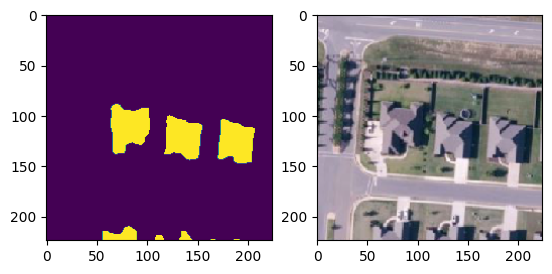

In [35]:
idx = 0
plt.subplot(1,2,2)
plt.imshow(images[idx].cpu().permute(1,2,0))
plt.subplot(1,2,1)
plt.imshow(outputs[idx].cpu().squeeze(0) > .5)

In [178]:
outputs.shape

torch.Size([128, 1, 224, 224])

In [179]:
np.unique(outputs[10].sigmoid().cpu().numpy()).max()

0.9991586

# Aug_csv

In [5]:
transform_aug = get_transform_aug()
aug_dataset = SatelliteDataset(csv_file='/root/jupyter/Dacon/deeplabv3p/Archive/train_28049_2.csv', transform=transform_aug, infer= False)
aug_dataloader = DataLoader(aug_dataset, batch_size=10000, shuffle=False, num_workers=4)

# Prac

In [150]:
aug_iter = iter(aug_dataloader)

In [238]:
aug_iter = iter(aug_dataloader)
imgs,msks = next(aug_iter)

In [239]:
len(imgs)

8049

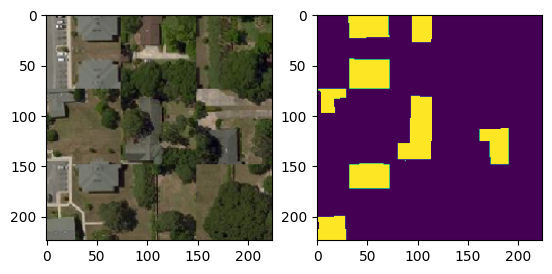

In [155]:
idx = 3
plt.subplot(1,2,1)
plt.imshow(imgs[idx])
plt.subplot(1,2,2)
plt.imshow(msks[idx])

# Remove Data

In [1701]:
train_df = pd.read_csv('./train_28049_2.csv')

In [1702]:
train_df

img_id                            img_path  \
0      TRAIN_5425_10  ./train_img_crop/TRAIN_5425_10.png   
1      TRAIN_2224_19  ./train_img_crop/TRAIN_2224_19.png   
2      TRAIN_1157_19  ./train_img_crop/TRAIN_1157_19.png   
3      TRAIN_6761_25  ./train_img_crop/TRAIN_6761_25.png   
4       TRAIN_3521_9   ./train_img_crop/TRAIN_3521_9.png   
...              ...                                 ...   
28044   TRAIN_5274_2   ./train_img_crop/TRAIN_5274_2.png   
28045   TRAIN_4395_2   ./train_img_crop/TRAIN_4395_2.png   
28046  TRAIN_4806_10  ./train_img_crop/TRAIN_4806_10.png   
28047  TRAIN_6185_19  ./train_img_crop/TRAIN_6185_19.png   
28048  TRAIN_5342_24  ./train_img_crop/TRAIN_5342_24.png   

                                                mask_rle  
0      247 12 470 13 695 12 717 1 919 12 1143 13 1160...  
1      66 22 290 22 514 22 738 22 962 22 1186 22 1411...  
2      92 6 193 28 319 2 417 26 642 23 866 21 1091 19...  
3      32 40 170 20 256 40 394 20 480 40 618 20 704 4...  
4                                                     -1  
...                                                  ...  
28044  68 14 190 22 291 15 414 22 513 18 638 22 736 2...  
28045                                                 -1  
28046                                                 -1  
28047  98 24 323 24 548 24 773 24 997 25 1221 26 1445...  
28048  13790 1 13843 2 14066 5 14206 31 14290 7 14391...  

[28049 rows x 3 columns]

In [2861]:
rmv_idx = [1703,2120,3261,3746,13622,14932,16458,16962,49,299,934,1885,5330,6483,6682,22116,25246,154,787,1994,7705,7950,8217,8973,9147,11272,11790,12898,14246,14738,15470,17766,17962,18590,19728,21063,21082,21104,21283,21427,21809,23257,23694,25263,25674,27085,27106]

In [2832]:
rm_idx = [299,934,1885,5330,6483,6682,22116,25246]

In [2847]:
r_idx = [1703,2120,3261,3746,13622,14932,16458,16962]

In [2862]:
len(rmv_idx)

47

In [2789]:
rmv_idx[16]

17692

In [2848]:
i = 0

In [2860]:
idx = r_idx[i]
plt.figure(figsize = (13,13))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(origin_train_df['img_path'][idx]))
plt.subplot(1,2,2)
plt.imshow(rle_decode(origin_train_df['mask_rle'][idx], shape = (224,224)))
i += 1

IndexError: list index out of range

In [2858]:
idx

16458

In [2839]:
i

5

In [2863]:
refined_df = train_df.drop(rmv_idx).reset_index()

In [2864]:
refined_df

index         img_id                            img_path  \
0          0  TRAIN_5425_10  ./train_img_crop/TRAIN_5425_10.png   
1          1  TRAIN_2224_19  ./train_img_crop/TRAIN_2224_19.png   
2          2  TRAIN_1157_19  ./train_img_crop/TRAIN_1157_19.png   
3          3  TRAIN_6761_25  ./train_img_crop/TRAIN_6761_25.png   
4          4   TRAIN_3521_9   ./train_img_crop/TRAIN_3521_9.png   
...      ...            ...                                 ...   
27997  28044   TRAIN_5274_2   ./train_img_crop/TRAIN_5274_2.png   
27998  28045   TRAIN_4395_2   ./train_img_crop/TRAIN_4395_2.png   
27999  28046  TRAIN_4806_10  ./train_img_crop/TRAIN_4806_10.png   
28000  28047  TRAIN_6185_19  ./train_img_crop/TRAIN_6185_19.png   
28001  28048  TRAIN_5342_24  ./train_img_crop/TRAIN_5342_24.png   

                                                mask_rle  
0      247 12 470 13 695 12 717 1 919 12 1143 13 1160...  
1      66 22 290 22 514 22 738 22 962 22 1186 22 1411...  
2      92 6 193 28 319 2 417 26 642 23 866 21 1091 19...  
3      32 40 170 20 256 40 394 20 480 40 618 20 704 4...  
4                                                     -1  
...                                                  ...  
27997  68 14 190 22 291 15 414 22 513 18 638 22 736 2...  
27998                                                 -1  
27999                                                 -1  
28000  98 24 323 24 548 24 773 24 997 25 1221 26 1445...  
28001  13790 1 13843 2 14066 5 14206 31 14290 7 14391...  

[28002 rows x 4 columns]

In [2865]:
r_df = refined_df.drop(columns='index')

In [2866]:
r_df

img_id                            img_path  \
0      TRAIN_5425_10  ./train_img_crop/TRAIN_5425_10.png   
1      TRAIN_2224_19  ./train_img_crop/TRAIN_2224_19.png   
2      TRAIN_1157_19  ./train_img_crop/TRAIN_1157_19.png   
3      TRAIN_6761_25  ./train_img_crop/TRAIN_6761_25.png   
4       TRAIN_3521_9   ./train_img_crop/TRAIN_3521_9.png   
...              ...                                 ...   
27997   TRAIN_5274_2   ./train_img_crop/TRAIN_5274_2.png   
27998   TRAIN_4395_2   ./train_img_crop/TRAIN_4395_2.png   
27999  TRAIN_4806_10  ./train_img_crop/TRAIN_4806_10.png   
28000  TRAIN_6185_19  ./train_img_crop/TRAIN_6185_19.png   
28001  TRAIN_5342_24  ./train_img_crop/TRAIN_5342_24.png   

                                                mask_rle  
0      247 12 470 13 695 12 717 1 919 12 1143 13 1160...  
1      66 22 290 22 514 22 738 22 962 22 1186 22 1411...  
2      92 6 193 28 319 2 417 26 642 23 866 21 1091 19...  
3      32 40 170 20 256 40 394 20 480 40 618 20 704 4...  
4                                                     -1  
...                                                  ...  
27997  68 14 190 22 291 15 414 22 513 18 638 22 736 2...  
27998                                                 -1  
27999                                                 -1  
28000  98 24 323 24 548 24 773 24 997 25 1221 26 1445...  
28001  13790 1 13843 2 14066 5 14206 31 14290 7 14391...  

[28002 rows x 3 columns]

In [2867]:
r_df.to_csv('train_28002.csv', index = False)

# Read CSV

In [3]:
train_150K = pd.read_csv('train_#_150K.csv')

In [4]:
train_150K

img_id                            img_path  \
0       TRAIN_0903_18  ./train_img_crop/TRAIN_0903_18.png   
1       TRAIN_0134_16  ./train_img_crop/TRAIN_0134_16.png   
2       TRAIN_2159_13  ./train_img_crop/TRAIN_2159_13.png   
3       TRAIN_3409_14  ./train_img_crop/TRAIN_3409_14.png   
4       TRAIN_0641_25  ./train_img_crop/TRAIN_0641_25.png   
...               ...                                 ...   
149761  TRAIN_5623_18  ./train_img_crop/TRAIN_5623_18.png   
149762  TRAIN_1621_17  ./train_img_crop/TRAIN_1621_17.png   
149763   TRAIN_1424_8   ./train_img_crop/TRAIN_1424_8.png   
149764  TRAIN_1478_18  ./train_img_crop/TRAIN_1478_18.png   
149765  TRAIN_2063_16  ./train_img_crop/TRAIN_2063_16.png   

                                                 mask_rle  
0       418 1 641 3 864 5 1087 7 1310 9 1533 11 1548 1...  
1       207 18 431 18 655 18 879 18 23960 9 24181 12 2...  
2       7452 12 7676 12 7900 12 8124 12 8348 12 8572 1...  
3                                                      -1  
4       19 24 243 24 467 24 691 24 915 24 1139 24 1363...  
...                                                   ...  
149761  15 17 157 32 239 17 381 32 463 17 605 32 687 1...  
149762  28134 1 28352 7 28571 13 28790 18 29008 24 292...  
149763  12512 14 12736 14 12960 14 13184 14 13408 14 1...  
149764  44 19 91 2 209 14 268 19 433 14 492 19 657 14 ...  
149765  19001 3 19224 5 19447 7 19670 9 19893 11 20116...  

[149766 rows x 3 columns]

In [6]:
train_28K = pd.read_csv('./Archive/train_28049_2.csv')

In [7]:
augged_id_list = []
augged_path_list = []
for i in range(len(train_28K)):
    augged_id_list.append(train_28K['img_id'][i])
    path = os.path.join('./train_img_auged_28K/' +train_28K['img_id'][i]+'.png')
    augged_path_list.append(path)

In [8]:
print(len(augged_id_list))
print(len(augged_path_list))

28049
28049


In [9]:
augged_id_list[-5:]

['TRAIN_5274_2',
 'TRAIN_4395_2',
 'TRAIN_4806_10',
 'TRAIN_6185_19',
 'TRAIN_5342_24']

In [10]:
augged_path_list[-5:]

['./train_img_auged_28K/TRAIN_5274_2.png',
 './train_img_auged_28K/TRAIN_4395_2.png',
 './train_img_auged_28K/TRAIN_4806_10.png',
 './train_img_auged_28K/TRAIN_6185_19.png',
 './train_img_auged_28K/TRAIN_5342_24.png']

In [12]:
transform_aug = get_transform_aug()
aug_dataset = SatelliteDataset(csv_file='/root/jupyter/Dacon/deeplabv3p/train_#_150K.csv', transform=transform_aug, infer= False)
aug_dataloader = DataLoader(aug_dataset, batch_size=10000, shuffle=False, num_workers=4)

In [11]:
augged_rle = []
step = 0
for imgs, msks in tqdm(aug_dataloader):
    for i in range(len(msks)):
        rled = rle_encode(msks[i])
        augged_rle.append(rled)
        save_img(imgs[i],augged_path_list[i+(10000*step)])
    step += 1

100% 3/3 [02:00<00:00, 40.25s/it]


In [35]:
augged_rle

['255 1 478 3 701 5 924 7 1147 9 1365 1 1370 11 1588 18 1811 20 2034 22 2257 24 2480 26 2703 28 2926 30 3149 32 3372 34 3597 34 3822 34 4047 34 4272 34 4497 34 4722 34 4947 34 5172 34 5397 34 5622 33 5847 31 6072 28 6297 26 6521 25 6745 14 6761 8 6968 14 6986 6 7191 14 7211 4 7414 14 7436 2 7639 12 7864 10 8089 8 8314 6 8539 3 8764 1 19145 1 19368 3 19591 5 19814 7 20037 9 20260 11 20483 13 20706 15 20929 17 21152 19 21375 21 21598 23 21822 24 22047 24 22272 24 22497 24 22721 25 22946 25 23170 26 23393 28 23616 30 23839 32 24063 33 24288 33 24513 33 24738 33 24963 33 25188 33 25413 33 25638 33 25863 33 26088 32 26313 3 26319 25 26538 1 26544 23 26769 21 26994 19 27219 17 27444 14 27669 12 27894 10 28118 9 28343 7 28568 5 28790 1 28793 3 29018 1 32749 4 32970 7 33193 9 33417 9 33642 8 33866 8 34090 9 34315 8 34539 8 34763 9 34984 12 35206 14 35430 15 35654 15 35879 14 36103 14 36327 15 36552 14 36776 14 37000 15 37224 15 37449 14 37673 13 37897 10 38122 6 38346 2 45411 1 45853 17 46077 

In [12]:
augged_dict = {'img_id' : augged_id_list,
               'img_path' : augged_path_list,
               'mask_rle' : augged_rle
              }
augged_df = pd.DataFrame(augged_dict)
#augged_df.to_csv(path_or_buf = './train_img_auged_150K.csv', index = False)

In [14]:
tmp_replace = augged_df['mask_rle'].replace('','-1')

In [27]:
augged_df['mask_rle'] = tmp_replace

In [28]:
augged_df

img_id                                 img_path  \
0      TRAIN_5425_10  ./train_img_auged_28K/TRAIN_5425_10.png   
1      TRAIN_2224_19  ./train_img_auged_28K/TRAIN_2224_19.png   
2      TRAIN_1157_19  ./train_img_auged_28K/TRAIN_1157_19.png   
3      TRAIN_6761_25  ./train_img_auged_28K/TRAIN_6761_25.png   
4       TRAIN_3521_9   ./train_img_auged_28K/TRAIN_3521_9.png   
...              ...                                      ...   
28044   TRAIN_5274_2   ./train_img_auged_28K/TRAIN_5274_2.png   
28045   TRAIN_4395_2   ./train_img_auged_28K/TRAIN_4395_2.png   
28046  TRAIN_4806_10  ./train_img_auged_28K/TRAIN_4806_10.png   
28047  TRAIN_6185_19  ./train_img_auged_28K/TRAIN_6185_19.png   
28048  TRAIN_5342_24  ./train_img_auged_28K/TRAIN_5342_24.png   

                                                mask_rle  
0      415 12 639 13 852 1 863 12 1087 12 1292 14 131...  
1      151 74 375 74 599 74 823 74 1047 74 1271 74 14...  
2      53 6 80 28 278 2 306 26 532 23 758 21 983 19 1...  
3      32 40 170 20 256 40 394 20 480 40 618 20 704 4...  
4                                                     -1  
...                                                  ...  
28044  1546 8 1756 22 1980 22 2204 22 2428 22 2652 22...  
28045                                                 -1  
28046                                                 -1  
28047  74 27 186 24 298 27 410 24 522 27 634 24 746 2...  
28048  13790 1 13843 2 14066 5 14206 31 14290 7 14391...  

[28049 rows x 3 columns]

In [37]:
augged_df.to_csv('train_auged_28K.csv',index = False)

In [39]:
tmp_replace = augged_df['mask_rle'].replace('','-1')

In [76]:
augged_df = pd.read_csv('./train_img_auged.csv')

In [25]:
augged_df = augged_df.fillna(-1)

In [33]:
tmp_augged_df = augged_df

In [42]:
tmp_augged_df['mask_rle'] = tmp_augged_df['mask_rle'].replace('','-1')

In [43]:
tmp_augged_df

img_id                                  img_path  \
0       TRAIN_0903_18  ./train_img_auged_150K/TRAIN_0903_18.png   
1       TRAIN_0134_16  ./train_img_auged_150K/TRAIN_0134_16.png   
2       TRAIN_2159_13  ./train_img_auged_150K/TRAIN_2159_13.png   
3       TRAIN_3409_14  ./train_img_auged_150K/TRAIN_3409_14.png   
4       TRAIN_0641_25  ./train_img_auged_150K/TRAIN_0641_25.png   
...               ...                                       ...   
149761  TRAIN_5623_18  ./train_img_auged_150K/TRAIN_5623_18.png   
149762  TRAIN_1621_17  ./train_img_auged_150K/TRAIN_1621_17.png   
149763   TRAIN_1424_8   ./train_img_auged_150K/TRAIN_1424_8.png   
149764  TRAIN_1478_18  ./train_img_auged_150K/TRAIN_1478_18.png   
149765  TRAIN_2063_16  ./train_img_auged_150K/TRAIN_2063_16.png   

                                                 mask_rle  
0       255 1 478 3 701 5 924 7 1147 9 1365 1 1370 11 ...  
1       18358 11 18582 11 18806 11 19030 11 19254 11 1...  
2       2627 28 2851 40 3075 40 3299 40 3522 41 3746 4...  
3                                                      -1  
4       19 24 243 24 467 24 691 24 915 24 1139 24 1363...  
...                                                   ...  
149761  32 32 189 19 256 32 413 19 480 32 637 19 704 3...  
149762  28134 1 28352 7 28571 13 28790 18 29008 24 292...  
149763  12340 14 12564 14 12788 14 13012 14 13236 14 1...  
149764  86 13 310 30 534 30 758 30 809 1 982 30 1033 4...  
149765  19001 3 19224 5 19447 7 19670 9 19893 11 20116...  

[149766 rows x 3 columns]

In [32]:
augged_df['mask_rle'][3]

''

In [44]:
tmp_augged_df.to_csv('./train_img_auged_150K.csv', index = False)

In [43]:
augged_df['img_path'][0]

'./train_img_auged/TRAIN_5425_10.png'

In [3]:
transform = get_transform_for_test()
aug_dataset = SatelliteDataset(csv_file='/root/jupyter/Dacon/deeplabv3p/train_img_auged_150K.csv', transform=transform, infer= False)
aug_dataloader = DataLoader(aug_dataset, batch_size=10000, shuffle=False, num_workers=4)

In [4]:
aug_iter = iter(aug_dataloader)

In [5]:
i = 0

In [34]:
imgs,msks = next(aug_iter)

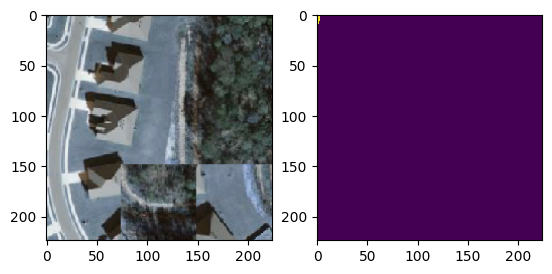

In [52]:
idx = 10
plt.subplot(1,2,1)
plt.imshow(imgs[idx].permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(msks[idx].squeeze(0))
i+=1

In [36]:
i

13

In [38]:
auged_df = pd.read_csv('train_img_auged_150K.csv')

In [40]:
auged_df['img_path']

'./train_img_auged_150K/TRAIN_0903_18.png'

In [42]:
idx = 0

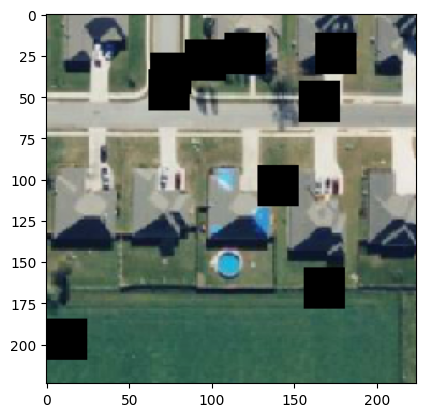

In [54]:
idx +=1
plt.imshow(cv2.imread(auged_df['img_path'][10000*idx +1234]))

In [39]:
auged_df['img_path'][111234]

'./train_img_auged_150K/TRAIN_0490_25.png'

In [40]:
auged_df['img_path'][120003]

'./train_img_auged_150K/TRAIN_6638_5.png'

In [44]:
auged_df['img_path'][120006]

'./train_img_auged_150K/TRAIN_2502_17.png'

In [53]:
auged_df['img_path'][120010]

'./train_img_auged_150K/TRAIN_1231_12.png'

In [46]:
origin_train_df = pd.read_csv('train.csv')

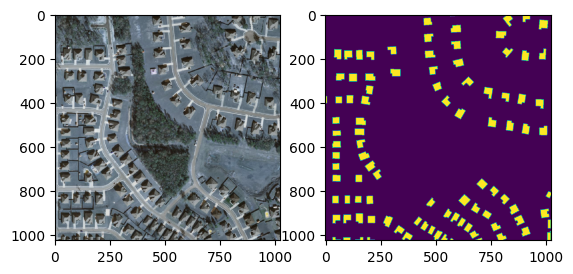

In [54]:
plt.subplot(1,2,1)
plt.imshow(cv2.imread(origin_train_df['img_path'][1231]))
plt.subplot(1,2,2)
plt.imshow(rle_decode(origin_train_df['mask_rle'][1231],shape = (1024,1024)))

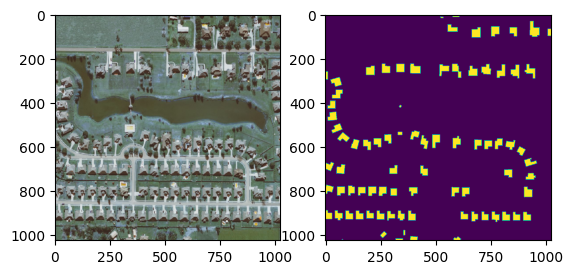

In [65]:
plt.subplot(1,2,1)
plt.imshow(cv2.imread(origin_train_df['img_path'][490]))
plt.subplot(1,2,2)
plt.imshow(rle_decode(origin_train_df['mask_rle'][490],shape = (1024,1024)))

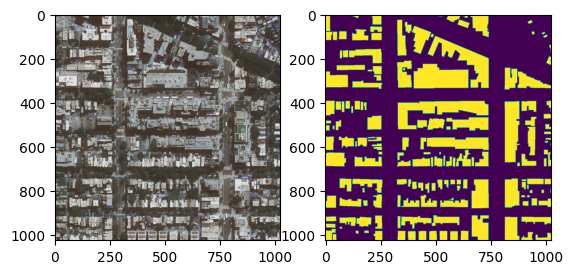

In [48]:
plt.subplot(1,2,1)
plt.imshow(cv2.imread(origin_train_df['img_path'][6638]))
plt.subplot(1,2,2)
plt.imshow(rle_decode(origin_train_df['mask_rle'][6638],shape = (1024,1024)))

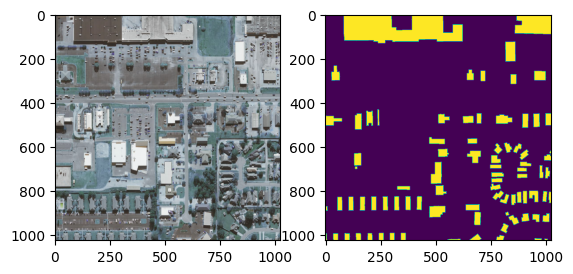

In [47]:
plt.subplot(1,2,1)
plt.imshow(cv2.imread(origin_train_df['img_path'][2502]))
plt.subplot(1,2,2)
plt.imshow(rle_decode(origin_train_df['mask_rle'][2502],shape = (1024,1024)))


In [ ]:
plt.subplot(1,2,1)
plt.imshow(cv2.imread(origin_train_df['img_path'][6638]))
plt.subplot(1,2,2)
plt.imshow(rle_decode(origin_train_df['mask_rle'][6638],shape = (1024,1024)))


In [66]:
tmp_augged_df['img_path'][35555]

'./train_img_auged_150K/TRAIN_6881_4.png'

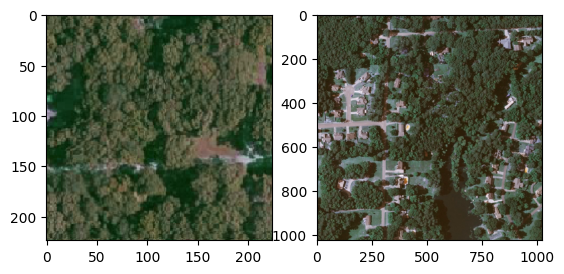

In [78]:
plt.subplot(1,2,1)
plt.imshow(cv2.imread('./train_img_auged_150K/TRAIN_6881_4.png'))
plt.subplot(1,2,2)
plt.imshow(cv2.imread('./train_img/TRAIN_6881.png'))

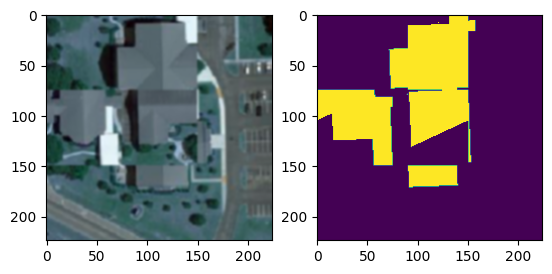

In [93]:
idx = 9999
plt.subplot(1,2,1)
plt.imshow(imgs[idx].permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(msks[idx].squeeze(0))

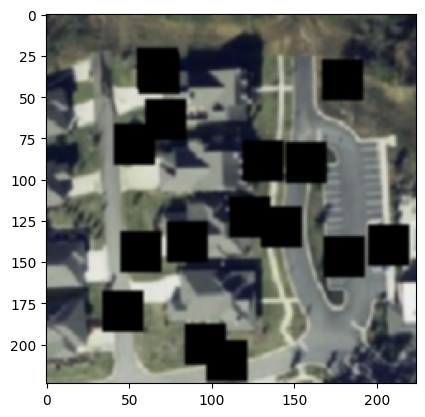

In [57]:
plt.imshow(cv2.imread('./train_img_auged/TRAIN_2484_6.png'))

In [258]:
img = cv2.imread(augged_path_list[10000])

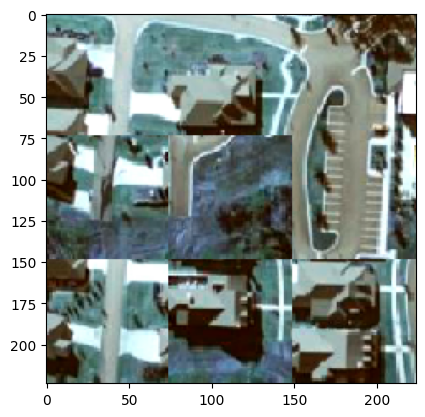

In [259]:
plt.imshow(img)

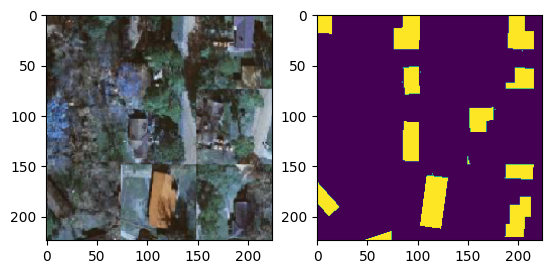

In [274]:
idx = 10006
img = cv2.imread(augged_path_list[idx])
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(rle_decode(augged_df['mask_rle'][idx], shape = (224,224)))

In [284]:
transform = get_transform_for_test()
dataset = SatelliteDataset(csv_file='./train_img_auged.csv', transform=transform, infer= False)
dataloader = DataLoader(aug_dataset, batch_size=10000, shuffle=False, num_workers=4)

In [285]:
data_iter = iter(dataloader)

In [304]:
imgs,msks = next(data_iter)

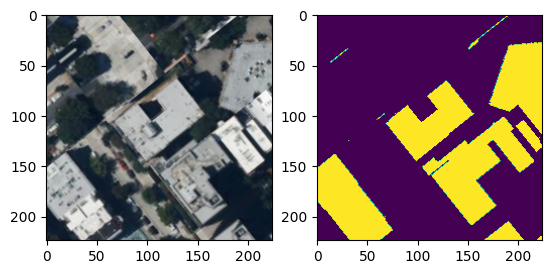

In [306]:
idx = 1
plt.subplot(1,2,1)
plt.imshow(imgs[idx])
plt.subplot(1,2,2)
plt.imshow(msks[idx])

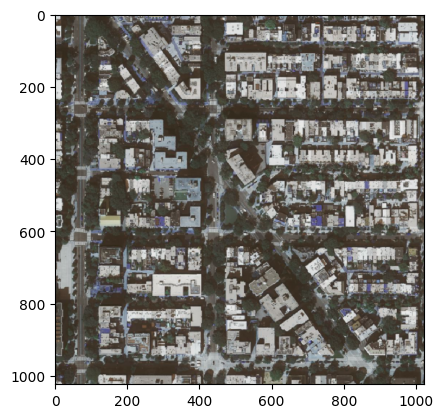

In [314]:
plt.imshow(cv2.imread(origin_train['img_path'][4496]))

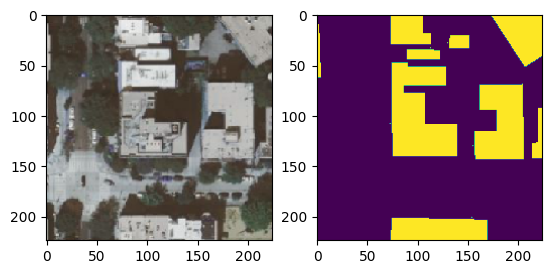

In [315]:
plt.subplot(1,2,1)
plt.imshow(cv2.imread(train_28049_2['img_path'][20001]))
plt.subplot(1,2,2)
plt.imshow(rle_decode(train_28049_2['mask_rle'][20001], shape = (224,224)))

In [308]:
train_28049_2['img_id'][20001]

'TRAIN_4496_23'

In [298]:
origin_train = pd.read_csv('./train.csv')

In [312]:
origin_train

img_id                    img_path  \
0     TRAIN_0000  ./train_img/TRAIN_0000.png   
1     TRAIN_0001  ./train_img/TRAIN_0001.png   
2     TRAIN_0002  ./train_img/TRAIN_0002.png   
3     TRAIN_0003  ./train_img/TRAIN_0003.png   
4     TRAIN_0004  ./train_img/TRAIN_0004.png   
...          ...                         ...   
7135  TRAIN_7135  ./train_img/TRAIN_7135.png   
7136  TRAIN_7136  ./train_img/TRAIN_7136.png   
7137  TRAIN_7137  ./train_img/TRAIN_7137.png   
7138  TRAIN_7138  ./train_img/TRAIN_7138.png   
7139  TRAIN_7139  ./train_img/TRAIN_7139.png   

                                               mask_rle  
0     9576 7 10590 17 11614 17 12638 17 13662 17 146...  
1     208402 1 209425 6 210449 10 211473 14 212497 1...  
2     855 34 15654 9 16678 9 16742 8 17702 9 17766 9...  
3     362 6 745 15 798 22 900 25 1385 8 1828 16 1924...  
4     34 27 1058 27 2082 27 3105 27 4129 27 5153 27 ...  
...                                                 ...  
7135  193 19 882 18 985 21 1217 17 1782 2 1906 18 20...  
7136  85938 13 86962 20 87986 20 89009 21 90033 21 9...  
7137  100 59 314 28 878 28 997 20 1124 59 1338 28 19...  
7138  789 18 975 17 1814 16 2000 14 2544 2 2839 14 3...  
7139  711 19 821 17 924 101 1740 14 1844 19 1948 101...  

[7140 rows x 3 columns]

In [301]:
origin_train['mask_rle'][1441]

'865 25 1889 26 2914 26 3939 26 4964 26 5989 26 7014 25 8039 23 9064 21 10089 19 11114 17 12139 15 13164 13 14189 11 15214 9 16239 7 17264 5 18289 3 19314 1 28184 1 29207 3 30230 5 31253 7 32276 9 33299 11 34323 12 35346 15 36369 17 37392 19 38415 21 39438 23 40461 25 41486 25 42511 25 43532 1 43536 24 44561 22 44850 2 45586 20 45873 6 46611 18 46897 8 47636 16 47921 11 48661 14 48944 15 49686 12 49968 17 50711 10 50991 18 51736 8 52015 18 52762 6 53039 17 53787 4 54062 18 54812 2 55086 18 56109 18 57133 18 58157 17 59180 18 60204 18 61228 17 62251 18 63275 18 64298 18 65322 18 66346 17 67369 18 68393 18 69417 17 70440 18 71464 17 72487 18 73511 18 74512 3 74536 16 75535 7 75562 14 76559 10 76589 11 77583 13 77616 7 78606 17 78642 5 79630 20 79669 1 80654 23 81677 26 82701 29 83725 32 84748 36 85772 39 86796 39 87819 40 88843 39 89866 40 90890 40 91914 39 92937 40 93961 40 94985 39 96008 40 97032 40 98056 39 99079 40 100103 40 101127 39 102151 39 103178 36 104205 32 105232 29 106259 26

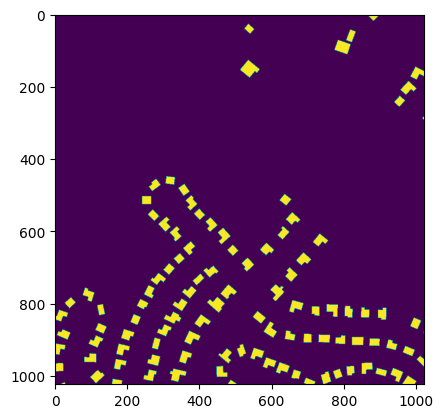

In [303]:
plt.imshow(rle_decode(origin_train['mask_rle'][1441], shape = (1024,1024)))

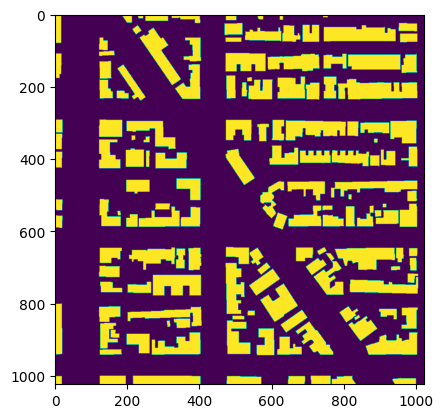

In [316]:
plt.imshow(rle_decode(origin_train['mask_rle'][4496], shape = (1024,1024)))

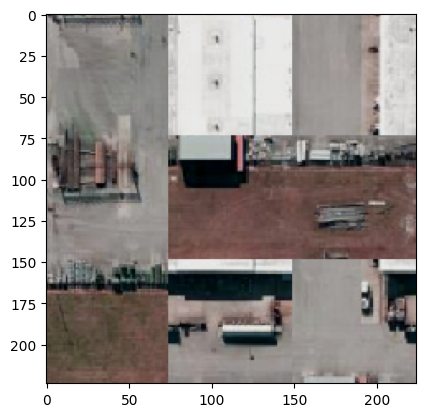

In [47]:
plt.imshow(cv2.imread('./train_img_auged/TRAIN_0000_10.png'))

In [58]:
class SatelliteDataset_aug(Dataset):
    def __init__(self, csv_file, transform=None, infer=False, auged = False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer
        self.auged = auged
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        if self.auged:
            os.chdir('/root/jupyter/Dacon/deeplabv3p')
            img_array = np.fromfile(img_path, np.uint8)
            image = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask


In [38]:
transform_aug = get_transform_for_test()
aug_dataset = SatelliteDataset(csv_file='/root/jupyter/Dacon/deeplabv3p/train_auged_28K.csv', transform=transform_aug, infer= False)
aug_dataloader = DataLoader(aug_dataset, batch_size=10000, shuffle=False, num_workers=4)

In [39]:
auged_df = pd.read_csv('train_auged_28K.csv')

In [40]:
auged_df

img_id                                 img_path  \
0      TRAIN_5425_10  ./train_img_auged_28K/TRAIN_5425_10.png   
1      TRAIN_2224_19  ./train_img_auged_28K/TRAIN_2224_19.png   
2      TRAIN_1157_19  ./train_img_auged_28K/TRAIN_1157_19.png   
3      TRAIN_6761_25  ./train_img_auged_28K/TRAIN_6761_25.png   
4       TRAIN_3521_9   ./train_img_auged_28K/TRAIN_3521_9.png   
...              ...                                      ...   
28044   TRAIN_5274_2   ./train_img_auged_28K/TRAIN_5274_2.png   
28045   TRAIN_4395_2   ./train_img_auged_28K/TRAIN_4395_2.png   
28046  TRAIN_4806_10  ./train_img_auged_28K/TRAIN_4806_10.png   
28047  TRAIN_6185_19  ./train_img_auged_28K/TRAIN_6185_19.png   
28048  TRAIN_5342_24  ./train_img_auged_28K/TRAIN_5342_24.png   

                                                mask_rle  
0      415 12 639 13 852 1 863 12 1087 12 1292 14 131...  
1      151 74 375 74 599 74 823 74 1047 74 1271 74 14...  
2      53 6 80 28 278 2 306 26 532 23 758 21 983 19 1...  
3      32 40 170 20 256 40 394 20 480 40 618 20 704 4...  
4                                                     -1  
...                                                  ...  
28044  1546 8 1756 22 1980 22 2204 22 2428 22 2652 22...  
28045                                                 -1  
28046                                                 -1  
28047  74 27 186 24 298 27 410 24 522 27 634 24 746 2...  
28048  13790 1 13843 2 14066 5 14206 31 14290 7 14391...  

[28049 rows x 3 columns]

In [41]:
data_iter = iter(aug_dataloader)

In [49]:
imgs,msks = next(data_iter)

In [51]:
len(imgs)

8049

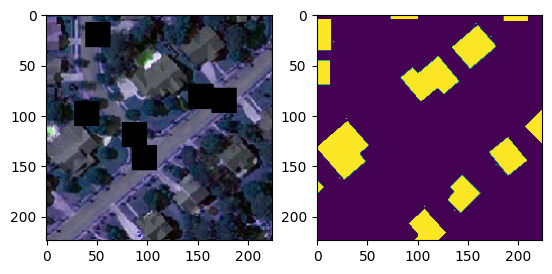

In [54]:
idx = 8047
plt.subplot(1,2,1)
plt.imshow(imgs[idx].permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(msks[idx].squeeze(0))

In [55]:
auged_28K_df = pd.read_csv('train_auged_28K.csv')

In [57]:
train_28K_df = pd.read_csv('./Archive/train_28049_2.csv')

In [58]:
total_df = auged_28K_df.append(train_28K_df)

/tmp/ipykernel_235559/395237224.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_df = auged_28K_df.append(train_28K_df)


In [63]:
reset_total_df = total_df.sample(frac = 1).reset_index(drop = True)

In [64]:
reset_total_df

img_id                                 img_path  \
0       TRAIN_6911_5        ./train_img_crop/TRAIN_6911_5.png   
1      TRAIN_1929_13  ./train_img_auged_28K/TRAIN_1929_13.png   
2      TRAIN_5533_25  ./train_img_auged_28K/TRAIN_5533_25.png   
3      TRAIN_4728_17       ./train_img_crop/TRAIN_4728_17.png   
4       TRAIN_7083_3        ./train_img_crop/TRAIN_7083_3.png   
...              ...                                      ...   
56093   TRAIN_1418_7   ./train_img_auged_28K/TRAIN_1418_7.png   
56094   TRAIN_0321_8        ./train_img_crop/TRAIN_0321_8.png   
56095  TRAIN_5224_20       ./train_img_crop/TRAIN_5224_20.png   
56096   TRAIN_4632_5   ./train_img_auged_28K/TRAIN_4632_5.png   
56097   TRAIN_1895_3   ./train_img_auged_28K/TRAIN_1895_3.png   

                                                mask_rle  
0      11463 9 11654 18 11687 9 11878 18 11911 9 1210...  
1      74 20 214 11 299 18 439 10 524 16 664 9 749 14...  
2      12769 1 12993 1 13217 1 13255 128 13441 1 1347...  
3      18022 18 18082 18 18232 3 18246 18 18278 17 18...  
4      18593 2 18817 4 19041 6 19265 8 19489 10 19713...  
...                                                  ...  
56093  1345 9 1569 9 1793 9 2017 9 2241 9 2465 9 2689...  
56094  19 18 53 18 93 25 133 92 277 18 317 25 357 92 ...  
56095  46 19 270 19 494 19 718 19 937 24 1161 24 1385...  
56096  7518 1 7738 5 7958 9 8179 13 8399 17 8619 21 8...  
56097  26 31 250 33 474 35 600 1 697 39 921 41 1144 4...  

[56098 rows x 3 columns]

In [65]:
reset_total_df.to_csv('train_origin_28K+auged_28K_auged.csv', index = False)

In [66]:
df = pd.read_csv('train_origin_28K+auged_28K_auged.csv')

In [67]:
df

img_id                                 img_path  \
0       TRAIN_6911_5        ./train_img_crop/TRAIN_6911_5.png   
1      TRAIN_1929_13  ./train_img_auged_28K/TRAIN_1929_13.png   
2      TRAIN_5533_25  ./train_img_auged_28K/TRAIN_5533_25.png   
3      TRAIN_4728_17       ./train_img_crop/TRAIN_4728_17.png   
4       TRAIN_7083_3        ./train_img_crop/TRAIN_7083_3.png   
...              ...                                      ...   
56093   TRAIN_1418_7   ./train_img_auged_28K/TRAIN_1418_7.png   
56094   TRAIN_0321_8        ./train_img_crop/TRAIN_0321_8.png   
56095  TRAIN_5224_20       ./train_img_crop/TRAIN_5224_20.png   
56096   TRAIN_4632_5   ./train_img_auged_28K/TRAIN_4632_5.png   
56097   TRAIN_1895_3   ./train_img_auged_28K/TRAIN_1895_3.png   

                                                mask_rle  
0      11463 9 11654 18 11687 9 11878 18 11911 9 1210...  
1      74 20 214 11 299 18 439 10 524 16 664 9 749 14...  
2      12769 1 12993 1 13217 1 13255 128 13441 1 1347...  
3      18022 18 18082 18 18232 3 18246 18 18278 17 18...  
4      18593 2 18817 4 19041 6 19265 8 19489 10 19713...  
...                                                  ...  
56093  1345 9 1569 9 1793 9 2017 9 2241 9 2465 9 2689...  
56094  19 18 53 18 93 25 133 92 277 18 317 25 357 92 ...  
56095  46 19 270 19 494 19 718 19 937 24 1161 24 1385...  
56096  7518 1 7738 5 7958 9 8179 13 8399 17 8619 21 8...  
56097  26 31 250 33 474 35 600 1 697 39 921 41 1144 4...  

[56098 rows x 3 columns]